# Import the libraries needed
These should be specific to the task at hand which in this case is hyperparameter tuning and classification

In [1]:
#importing necessary libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve


from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import accuracy_score,classification_report
import seaborn as sns

smclient = boto3.Session().client('sagemaker')
# Define IAM role
role = get_execution_role()
prefix = '******************'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + 
      " region. You will use the " + xgboost_container + 
      " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-west-1 region. You will use the 632365934929.dkr.ecr.us-west-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


# Create bucket if not pre-existing
In this case it was created already

In [2]:
##name of pre-existing bucket
bucket_name = '*************' 

# Upload the data to the bucket
Data was already explicitly uploaded to our pre-existing bucket

In [3]:
try:
    model_data = pd.read_csv('************.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


# Standard train/test split of 70/30

In [4]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(3476, 7) (1490, 7)


# Visualize possible correlations
Possible feature engineering from data

<AxesSubplot:>

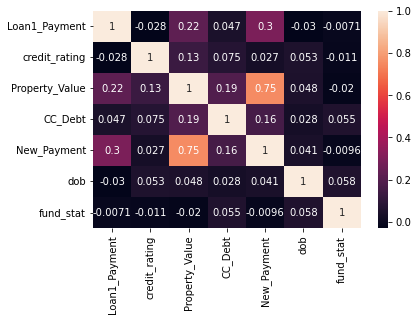

In [5]:
##heatmap for correlation
corrMatrix = model_data.corr()
sns.heatmap(corrMatrix, annot=True)

# Data in proper formats for tuning

In [6]:
##train set for hyperparameter tuning
pd.concat([train_data['fund_stat'], train_data.drop(['fund_stat'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')
##validation test set for hyperparameter tuning
pd.concat([test_data['fund_stat'], test_data.drop(['fund_stat'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_validation=sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

# Create session

In [7]:
sess = sagemaker.Session()

# Set your estimator

In [8]:
xgb = sagemaker.estimator.Estimator(
    xgboost_container,
    role,
    base_job_name="xgboost-random-search",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket_name, prefix),
    sagemaker_session=sess,
)

xgb.set_hyperparameters(
    eval_metric="auc",
    objective="binary:logistic",
    num_round=10,
    rate_drop=0.3,
    tweedie_variance_power=1.4,
)
objective_metric_name = "validation:auc"

# Logarithmic tuner
You are able to set the parameters to be tuned

In [9]:
##log tuner
hyperparameter_ranges = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
}

tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="xgb-randsearch-" + strftime("%Y%m%d-%H-%M-%S", gmtime()),
)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................!


# Check the progress

In [10]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

# Linear tuner
It's good to check both to find the best possible model

In [11]:
##linear tuner
hyperparameter_ranges_linear = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Linear"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Linear"),
}
tuner_linear = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

tuner_linear.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="xgb-linsearch-" + strftime("%Y%m%d-%H-%M-%S", gmtime()),
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................!


# Check progress

In [12]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

# Completing status of tunings

In [13]:
# check jobs have finished
status_log = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]


In [14]:
status_linear = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

In [15]:
assert status_log == "Completed", "First must be completed, was {}".format(status_log)
assert status_linear == "Completed", "Second must be completed, was {}".format(status_linear)

df_log = sagemaker.HyperparameterTuningJobAnalytics(
    tuner_log.latest_tuning_job.job_name
).dataframe()
df_linear = sagemaker.HyperparameterTuningJobAnalytics(
    tuner_linear.latest_tuning_job.job_name
).dataframe()
df_log["scaling"] = "log"
df_linear["scaling"] = "linear"
df = pd.concat([df_log, df_linear], ignore_index=True)

# Visualization of the scaling distribution of both models

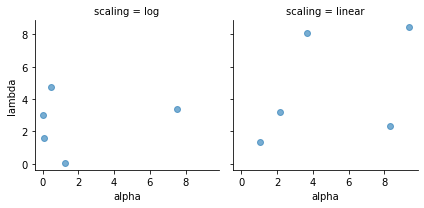

In [16]:
g = sns.FacetGrid(df, col="scaling", palette="viridis")
g = g.map(plt.scatter, "alpha", "lambda", alpha=0.6)

# Deploy the model

In [17]:
predictor = tuner_linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")


2022-10-18 17:24:15 Starting - Preparing the instances for training
2022-10-18 17:24:15 Downloading - Downloading input data
2022-10-18 17:24:15 Training - Training image download completed. Training in progress.
2022-10-18 17:24:15 Uploading - Uploading generated training model
2022-10-18 17:24:15 Completed - Resource retained for reuse
------!

# Endpoint name
Look for this in the bucket

In [18]:
predictor.endpoint_name

'xgb-linsearch-20221018-17-20-11-001-6089648f'

# Get the results in arrays for visualization

In [19]:
test_target=test_data['fund_stat']
test_data_array = test_data.drop(['fund_stat'], axis=1).values #load the data into an array
predictor.serializer = CSVSerializer() # set the serializer type
predictions = predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(1490,)


# Confusion matrix with accuracy

Text(0.5, 257.44, 'Predicted label')

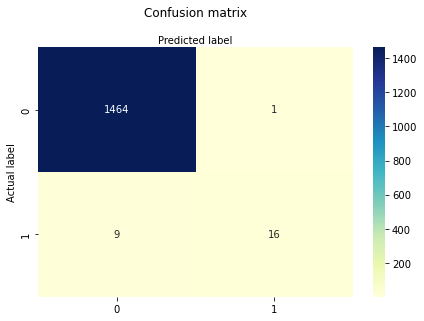

In [20]:
cm = metrics.confusion_matrix(test_target ,np.round(predictions_array))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [21]:
print(classification_report(test_target , np.round(predictions_array)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1465
           1       0.94      0.64      0.76        25

    accuracy                           0.99      1490
   macro avg       0.97      0.82      0.88      1490
weighted avg       0.99      0.99      0.99      1490



# Delete the endpoint and bucket

In [22]:
sess.delete_endpoint(endpoint_name=predictor.endpoint_name)

In [23]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': 'A5WYHBXBS1N26X1T',
   'HostId': 'y/HHuNcB/1liW9cDo5CY7nSi+36XMSNHLwXJLFGPNa0N0dBPoW1OOvnf+1WwIY/VUoM00VSYLWU=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'y/HHuNcB/1liW9cDo5CY7nSi+36XMSNHLwXJLFGPNa0N0dBPoW1OOvnf+1WwIY/VUoM00VSYLWU=',
    'x-amz-request-id': 'A5WYHBXBS1N26X1T',
    'date': 'Tue, 18 Oct 2022 17:28:33 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/xgboost-funded-data/output/xgb-randsearch-20221018-17-14-52-001-e9a7f03d/output/model.tar.gz'},
   {'Key': 'sagemaker/xgboost-funded-data/output/xgb-randsearch-20221018-17-14-52-003-61d16c35/output/model.tar.gz'},
   {'Key': 'sagemaker/xgboost-funded-data/output/xgb-randsearch-20221018-17-14-52-004-75c06df8/output/model.tar.gz'},
   {'Key': 'sagemaker/xgboost-funded-data/train/train.csv'},
   {'Key': 'sagemaker/xgboost-funded-data/ou